## PyTorch Workflow

Let's explore a an example PyTorch end-to-end workflow.

In [1]:
what_were_covering = {1: "data (prepare and load)",
                      2: "Build the model",
                      3: "Fitting the model to data (training)",
                      4: "making predictions and evaluating a model (inference)",
                      5: "Saving and loading a model",
                      6: "Putting it all together"}
what_were_covering

{1: 'data (prepare and load)',
 2: 'Build the model',
 3: 'Fitting the model to data (training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'Saving and loading a model',
 6: 'Putting it all together'}

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.1.2+cu121'

## Data (preparing and loading)

In [3]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets

In [5]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data?

This is where the data explorer's motto comes in!

In [6]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """
    Plots training data, test data and compares predictions.
    """

    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    # Are there predictions?
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Add legend to plot
    plt.legend(prop={"size": 14})


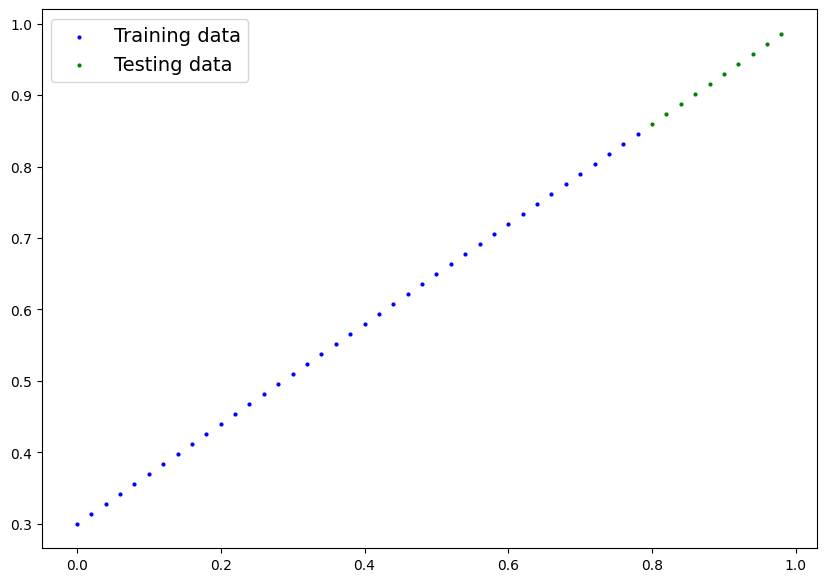

In [7]:
plot_predictions()

### Build a model

In [8]:
# Create linear regression model
class LinearRegression(nn.Module):

    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    # Forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x * self.weights + self.bias

In [9]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of our LinearRegression model
model_0 = LinearRegression()

# Check out the parameters of our model
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

In [11]:
y_preds_0 = model_0(X_test)
y_preds_0

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

In [12]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

# You can also use torch.no_grad(), however inference_mode() is more efficient
with torch.no_grad():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [13]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

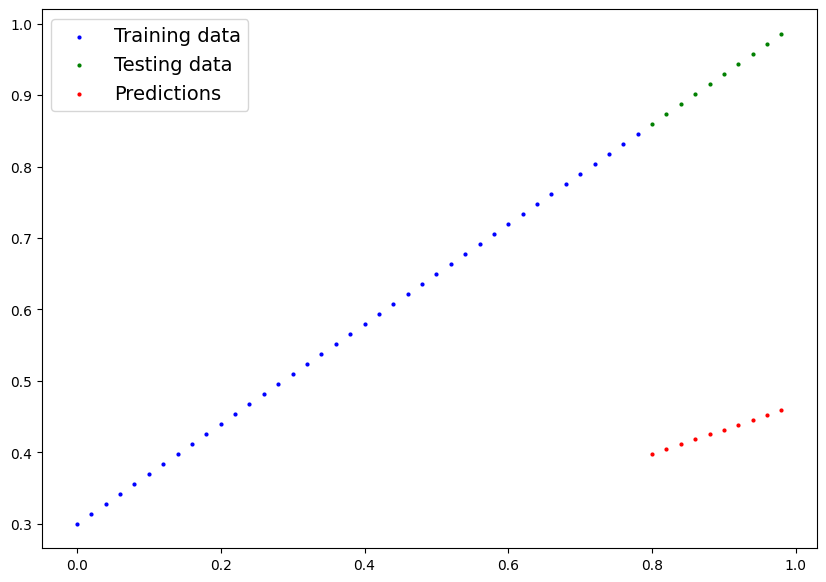

In [14]:
plot_predictions(predictions=y_preds)

## Training a model

The whole idea of training is for a model to move from some *unknown* parameters
(these may be random) to some *known* parameters.

Or in other words from a poor representation of the data to a better representation of the data.

One way to measure how poor or how wrong your models predictions are is to use a loss function.

* Note: Loss function may also be called cost function or criterion in different areas.
For our case, we're going to refer to it as a loss function.

Things we need to train:

* **Loss function**: A function to measure how wrong your model's prediction are to the ideal outputs,
lower is better.
* **Optimizer**: Takes into account the  loss of a model and adjusts the model's parameters (e.g. weight & bias)

And specifically for PyTorch, we need:

* Training Loop
* Testing Loop

In [15]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [16]:
# Check ot our model's parameters (a parameter is a value that the model sets itself)
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [17]:
# Set a loss function
loss_fn = nn.L1Loss()

# Set a optimizer
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.01)

### Building a training loop (and a testing loop) in PyTorch

In [18]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [19]:
# An epoch is one loop through the data
epochs = 200

# Track values
epoch_count = []
loss_value = []
test_loss_values = []

# 0. Loop through the data
for epoch in range(epochs):
    # Set the model to training mode
    model_0.train() # sets all parameters to requires_grad=True

    # 1. Forward pass
    y_pred = model_0(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Perform backpropagation on the loss with respect to the model parameters
    loss.backward()

    # 5. Step the optimizer (perform gradient descent)
    optimizer.step()

    ### Testing
    model_0.eval() # turns off different settings in the model not needed for evaluation (e.g. dropout)
    with torch.inference_mode(): # turns off gradient calculations
        # 1. Do the forward pass
        y_test_pred = model_0(X_test)

        # 2. Calculate the test loss
        test_loss = loss_fn(y_test_pred, y_test)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_value.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch {epoch} training loss: {loss}, test loss: {test_loss}")   

        print(model_0.state_dict())

Epoch 0 | Loss: 0.313 | Test loss: 0.481
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch 10 | Loss: 0.198 | Test loss: 0.346
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch 20 | Loss: 0.089 | Test loss: 0.217
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch 30 | Loss: 0.053 | Test loss: 0.145
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch 40 | Loss: 0.045 | Test loss: 0.114
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch 50 | Loss: 0.042 | Test loss: 0.099
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch 60 | Loss: 0.038 | Test loss: 0.089
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788]))])
Epoch 70 | Loss: 0.035 | Test loss: 0.081
OrderedDict([('weights', tensor([0.5288])), ('bias', tensor([0.3718]))])
Epoch 80 | Loss: 0.031 | Test loss: 0.072
OrderedDict([('weights', tensor([0.5459

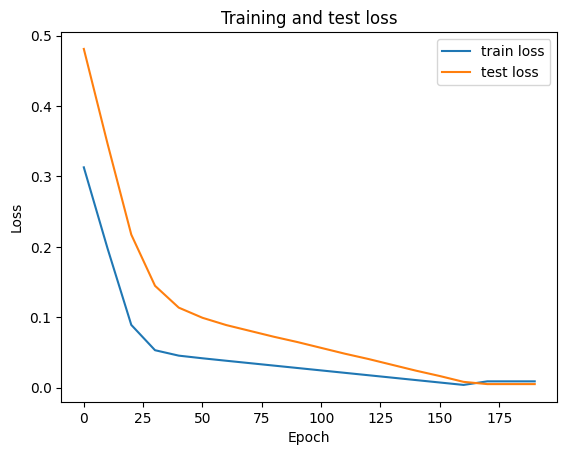

In [20]:
# Plot the loss curves
plt.plot(epoch_count, torch.tensor(loss_value), label="train loss")
plt.plot(epoch_count, torch.tensor(test_loss_values), label="test loss")
plt.title("Training and test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [21]:
with torch.inference_mode():
    y_preds = model_0(X_test)
y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

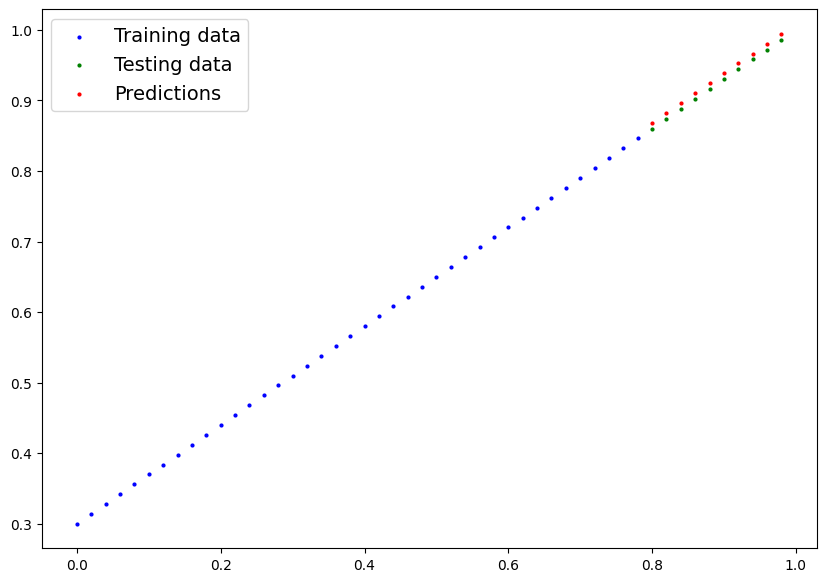

In [22]:
plot_predictions(predictions=y_preds)

In [23]:
print("updated model parameters:", model_0.state_dict())

updated model parameters: OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])
